In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

import torch

from captum.attr import (
    LayerGradCam,
    LayerAttribution,
    IntegratedGradients,
    Lime
)

from rgg.diffuser_utils import get_dataset
from rgg.datasets import GapPredictorDataset
from rgg.gap_predictor import get_gap_predictor
from rgg.plot_utils import plot_maze2d, plot_maze2d_observations, plot_maze2d_observations_with_attribution

In [4]:
class Args:
    env_name = 'maze2d-large-v1'
    data_path = '../../logs/data/maze2d-large-v1-H384-T256/500000_finish.npz'
    score_path = '../../logs/data/maze2d-large-v1-H384-T256/500000_finish_restoration_gaps.npy'
    planning_horizon = 384
    device = 'cuda'
    gap_predictor_path = '../../logs/gap_predictor/maze2d-large-v1-H384-T256/500000_finish/2023_03_26_03_44_06/seed_0/state_best.pt'
    
args = Args()

gap_predictor = get_gap_predictor('maze2d-large-v1').to(args.device)
gap_predictor.load_state_dict(
    torch.load(args.gap_predictor_path)['model']
)

# XAI methods ...
cam = LayerGradCam(gap_predictor, gap_predictor.backbone.mid_block)

normalizer = get_dataset(args.env_name).normalizer
test_dataset = GapPredictorDataset(
    args.env_name, 
    args.data_path,
    args.score_path,
    normalizer, 
    cutoff=0.03, # small values to see extreme cases
    mode='test'
)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
load datafile: 100%|███████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


[ utils/preprocessing ] Segmented maze2d-large-v1 | 1061 paths | min length: 67 | max length: 30470
[ datasets/buffer ] Finalized replay buffer | 1062 episodes
[ datasets/buffer ] Fields:
    actions: (1062, 40000, 2)
    infos/goal: (1062, 40000, 2)
    infos/qpos: (1062, 40000, 2)
    infos/qvel: (1062, 40000, 2)
    observations: (1062, 40000, 4)
    rewards: (1062, 40000, 1)
    terminals: (1062, 40000, 1)
    timeouts: (1062, 40000, 1)
    next_observations: (1062, 40000, 4)
    normed_observations: (1062, 40000, 4)
    normed_actions: (1062, 40000, 2)


In [9]:
data = np.load(args.data_path)
plan_observations = data['plan_observations']
plan_actions = data['plan_actions']
restoration_gaps = np.load(args.score_path)

sorted_idxs = np.argsort(restoration_gaps)[::-1] 
x_obs = plan_observations[sorted_idxs[:1000]]
x_obs = normalizer.normalize(x_obs, 'observations')
x_actions = plan_actions[sorted_idxs[:1000]]
x_actions = normalizer.normalize(x_actions, 'actions')
xs = np.concatenate([x_actions, x_obs], axis=-1)

(0.4, 10.6, 7.6, 0.4)

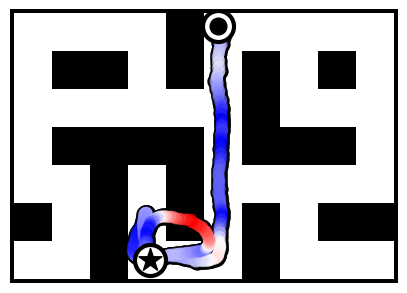

In [14]:
i = 137

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

timesteps = torch.tensor([0], device='cuda').long()
x = torch.tensor(xs[i][None, :], device='cuda')

attributions = cam.attribute(
    x.permute(0, 2, 1), 
    target=0, 
    additional_forward_args=timesteps,
)

if attributions.shape[-1] < args.planning_horizon:
    attributions = LayerAttribution.interpolate(attributions, (args.planning_horizon), interpolate_mode='linear')
attributions = attributions.permute(0, 2, 1)
attributions = torch.abs(attributions)
attributions = attributions.sum(axis=-1)
attributions = attributions.detach().cpu().numpy()

observations = normalizer.unnormalize(x[:, :, 2:].detach().cpu().numpy(), 'observations')
observations = observations[0]
attribution = attributions[0]

plot_maze2d('maze2d-large-v1', ax, fix_xy_lim=True)
plot_maze2d_observations_with_attribution(
    observations, attribution, ax=ax, goal=observations[-1, :2],
)
ax.axis('off')